In [1]:
!pip install scglue==0.3.2 anndata==0.8.0 scikit-misc faiss-gpu
!apt-get install bedtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [2]:
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz

--2024-12-06 04:06:01--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375260850 (358M) [application/x-tar]
Saving to: ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’

pbmc_unsorted_10k_f 100%[===================>] 357.88M   109MB/s    in 3.3s    

2024-12-06 04:06:04 (109 MB/s) - ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’ saved [375260850/375260850]



In [3]:
from itertools import chain
from random import Random

import anndata as ad
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [4]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [5]:
import tarfile

# 파일 경로 지정
file_path = "pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz"
output_dir = ""  # 압축을 풀 위치

# .tar.gz 파일 열기 및 해제
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(output_dir)

print(f"Files extracted to {output_dir}")

Files extracted to 


In [6]:
adata = sc.read_10x_mtx('filtered_feature_bc_matrix', gex_only=False)

In [7]:
adata

AnnData object with n_obs × n_vars = 12012 × 148458
    var: 'gene_ids', 'feature_types'

In [8]:
adata.var['feature_types'].value_counts()

,count
feature_types,
Peaks,111857
Gene Expression,36601


## stage 1

In [9]:
rna = adata[:, adata.var['feature_types'] == 'Gene Expression'].copy()
rna

AnnData object with n_obs × n_vars = 12012 × 36601
    var: 'gene_ids', 'feature_types'

In [10]:
atac = adata[:, adata.var['feature_types'] == 'Peaks'].copy()
atac

AnnData object with n_obs × n_vars = 12012 × 111857
    var: 'gene_ids', 'feature_types'

In [11]:
rna.X, rna.X.data

(<12012x36601 sparse matrix of type '<class 'numpy.float32'>'
 	with 22708400 stored elements in Compressed Sparse Row format>,
 array([ 1.,  1.,  1., ..., 22.,  2., 41.], dtype=float32))

In [12]:
rna.layers["counts"] = rna.X.copy()

In [13]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

In [14]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


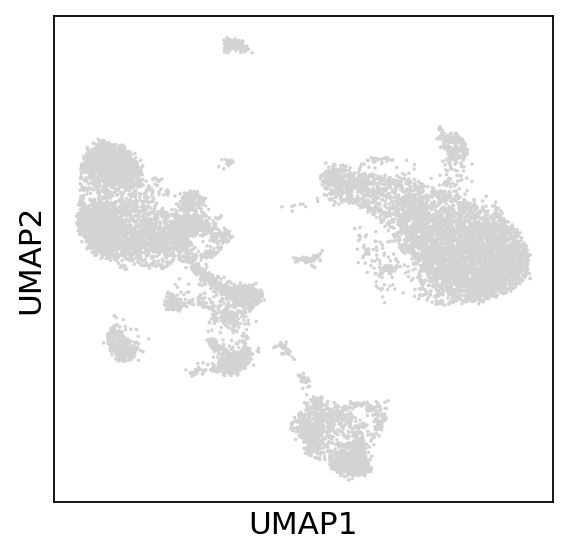

In [15]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna)

In [16]:
atac.X, atac.X.data

(<12012x111857 sparse matrix of type '<class 'numpy.float32'>'
 	with 79378359 stored elements in Compressed Sparse Row format>,
 array([2., 2., 2., ..., 2., 2., 2.], dtype=float32))

In [17]:
scglue.data.lsi(atac, n_components=100, n_iter=15)

In [18]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

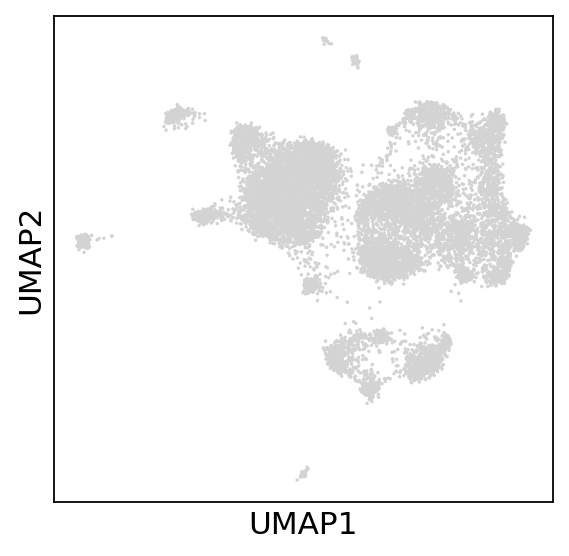

In [19]:
sc.pl.umap(atac)

In [20]:
rna.var.head()

,gene_ids,feature_types,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
MIR1302-2HG,ENSG00000243485,Gene Expression,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
FAM138A,ENSG00000237613,Gene Expression,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000
OR4F5,ENSG00000186092,Gene Expression,False,NaN,0.000083,0.000083,0.999655,0.000056,0.006140
AL627309.1,ENSG00000238009,Gene Expression,False,NaN,0.007742,0.008349,0.918610,0.004249,0.057480
AL627309.3,ENSG00000239945,Gene Expression,False,NaN,0.000250,0.000250,0.978342,0.000087,0.005646


In [21]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.v47.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
MIR1302-2HG,chr1,28588.0,31109.0
FAM138A,chr1,34552.0,37595.0
OR4F5,chr1,65418.0,71585.0
AL627309.1,NaN,NaN,NaN
AL627309.3,NaN,NaN,NaN


In [22]:
atac.var_names[:5]

Index(['chr1:9790-10676', 'chr1:180654-181318', 'chr1:191155-192066',
       'chr1:267573-268458', 'chr1:270881-271760'],
      dtype='object')

In [23]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,gene_ids,feature_types,chrom,chromStart,chromEnd
chr1:9790-10676,chr1:9790-10676,Peaks,chr1,9790,10676
chr1:180654-181318,chr1:180654-181318,Peaks,chr1,180654,181318
chr1:191155-192066,chr1:191155-192066,Peaks,chr1,191155,192066
chr1:267573-268458,chr1:267573-268458,Peaks,chr1,267573,268458
chr1:270881-271760,chr1:270881-271760,Peaks,chr1,270881,271760


In [24]:
columns_to_remove = ['highly_variable_rank', 'tag', 'artif_dupl']
rna.var = rna.var.drop(columns=columns_to_remove)

In [25]:
# Identify valid rows (no NA values)
valid_var_indices = rna.var.dropna().index

# Subset rna.var and rna.X
rna = rna[:, valid_var_indices]

# Drop unnecessary columns
columns_to_remove = ['highly_variable_rank', 'tag', 'artif_dupl']
# rna.var = rna.var.drop(columns=columns_to_remove)

# Verify changes
print(rna.var.isnull().sum())  # Ensure no missing values remain
print(rna.var.shape)          # Check dimensions after cleaning
print(rna.shape)              # Ensure consistency between rna.X and rna.var

gene_ids           0
feature_types      0
highly_variable    0
means              0
variances          0
variances_norm     0
mean               0
std                0
chrom              0
chromStart         0
chromEnd           0
name               0
score              0
strand             0
thickStart         0
thickEnd           0
itemRgb            0
blockCount         0
blockSizes         0
blockStarts        0
gene_id            0
gene_type          0
hgnc_id            0
havana_gene        0
dtype: int64
(23165, 24)
(12012, 23165)


In [26]:
rna.var

,gene_ids,feature_types,highly_variable,means,variances,variances_norm,mean,std,chrom,chromStart,...,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,gene_id,gene_type,hgnc_id,havana_gene
MIR1302-2HG,ENSG00000243485,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,28588.0,...,.,.,.,.,.,.,ENSG00000243485.6,lncRNA,HGNC:52482,OTTHUMG00000000959.2
FAM138A,ENSG00000237613,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,34552.0,...,.,.,.,.,.,.,ENSG00000237613.3,lncRNA,HGNC:32334,OTTHUMG00000000960.1
OR4F5,ENSG00000186092,Gene Expression,False,0.000083,0.000083,0.999655,0.000056,0.006140,chr1,65418.0,...,.,.,.,.,.,.,ENSG00000186092.7,protein_coding,HGNC:14825,OTTHUMG00000001094.4
OR4F29,ENSG00000284733,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,450739.0,...,.,.,.,.,.,.,ENSG00000284733.2,protein_coding,HGNC:31275,OTTHUMG00000002860.3
OR4F16,ENSG00000284662,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,685715.0,...,.,.,.,.,.,.,ENSG00000284662.2,protein_coding,HGNC:15079,OTTHUMG00000002581.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BPY2C,ENSG00000185894,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chrY,25030900.0,...,.,.,.,.,.,.,ENSG00000185894.8,protein_coding,HGNC:18225,OTTHUMG00000045199.3
TTTY4C,ENSG00000228296,Gene Expression,False,0.000083,0.000083,0.999655,0.000029,0.003209,chrY,25063082.0,...,.,.,.,.,.,.,ENSG00000228296.1,lncRNA,HGNC:31892,OTTHUMG00000045200.1
TTTY17C,ENSG00000223641,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chrY,25182266.0,...,.,.,.,.,.,.,ENSG00000223641.3,lncRNA,HGNC:31890,OTTHUMG00000045207.2
CDY1,ENSG00000172288,Gene Expression,False,0.000000,0.000000,0.000000,0.000000,1.000000,chrY,25622116.0,...,.,.,.,.,.,.,ENSG00000172288.8,protein_coding,HGNC:1809,OTTHUMG00000045274.2


In [27]:
print(rna.var.isnull().sum())
print(atac.shape)

gene_ids           0
feature_types      0
highly_variable    0
means              0
variances          0
variances_norm     0
mean               0
std                0
chrom              0
chromStart         0
chromEnd           0
name               0
score              0
strand             0
thickStart         0
thickEnd           0
itemRgb            0
blockCount         0
blockSizes         0
blockStarts        0
gene_id            0
gene_type          0
hgnc_id            0
havana_gene        0
dtype: int64
(12012, 111857)


In [28]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/23165 [00:00<?, ?it/s]

In [29]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...


INFO:check_graph:Checking variable coverage...


[INFO] check_graph: Checking edge attributes...


INFO:check_graph:Checking edge attributes...


[INFO] check_graph: Checking self-loops...


INFO:check_graph:Checking self-loops...


[INFO] check_graph: Checking graph symmetry...


INFO:check_graph:Checking graph symmetry...


[INFO] check_graph: All checks passed!


INFO:check_graph:All checks passed!


In [30]:
atac.var.head()

,gene_ids,feature_types,chrom,chromStart,chromEnd,highly_variable
chr1:9790-10676,chr1:9790-10676,Peaks,chr1,9790,10676,False
chr1:180654-181318,chr1:180654-181318,Peaks,chr1,180654,181318,False
chr1:191155-192066,chr1:191155-192066,Peaks,chr1,191155,192066,False
chr1:267573-268458,chr1:267573-268458,Peaks,chr1,267573,268458,False
chr1:270881-271760,chr1:270881-271760,Peaks,chr1,270881,271760,False


In [31]:
rna.write("rna-pp.h5ad", compression="gzip")
atac.write("atac-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "guidance.graphml.gz")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: